<a href="https://colab.research.google.com/github/efabless/tt_ml_test/blob/main/Pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An example implementation of a simple neural network using PyTorch and Tiny Tapeout

In this notebook, we are going to train a simple neural network using PyTorch and implement it in silicon using Tiny Tapeout.

This example reimplements the Hello World example presented in Chapter 4 of the TinyML book by Pat Warden.

https://www.oreilly.com/library/view/tinyml/9781492052036/ch04.html

---

**Author:** TBD

## Importing dependencies

In addition to PyTorch, we are going to use a Github project for converting a neural network model to Verilog.  

https://github.com/rohittp0/chipon/tree/master



In [ ]:
!git clone https://github.com/rohittp0/chipon
%cd chipon/

Cloning into 'chipon'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 40 (delta 1), reused 4 (delta 1), pack-reused 31
Receiving objects: 100% (40/40), 45.40 MiB | 31.93 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/chipon/chipon/chipon/chipon/chipon/chipon/chipon


In [ ]:
import torch
from torch import nn
import torch.quantization as quant

import numpy as np
import matplotlib.pyplot as plt
import math

import layers
from constants import test_bench_template
from main import Model
import os

## print out the pytorch version used
print(torch.__version__)

2.2.1+cu121


First generate the dataset representing a sinewave.

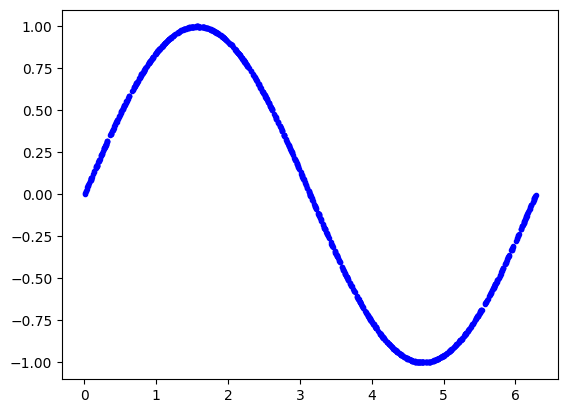

In [ ]:
# We'll generate this many sample datapoints
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook. Any number can be used here.
SEED = 1337
np.random.seed(SEED)

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
x_values = np.float32(x_values)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

Add noise to the data.

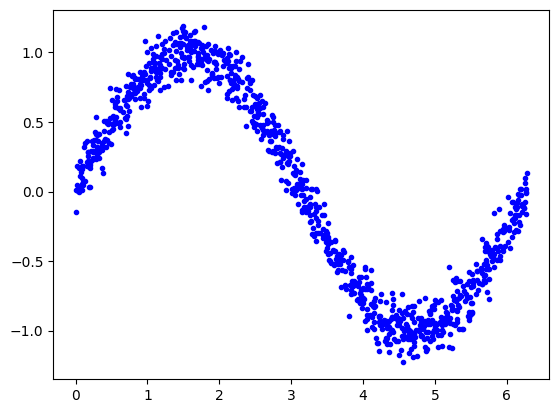

In [ ]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

Split the data into training, validation and test datasets

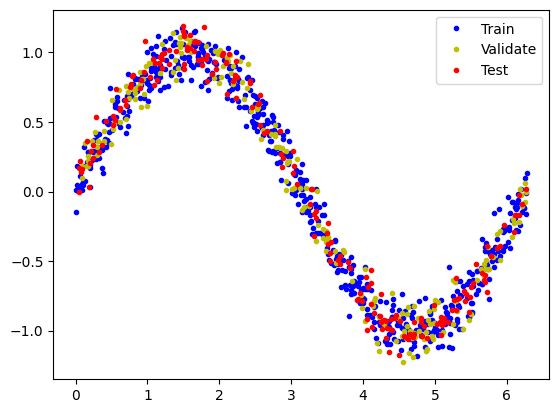

In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train_np, x_validate_np, x_test_np = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train_np, y_validate_np, y_test_np = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train_np.size + x_validate_np.size + x_test_np.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train_np, y_train_np, 'b.', label="Train")
plt.plot(x_validate_np, y_validate_np, 'y.', label="Validate")
plt.plot(x_test_np, y_test_np, 'r.', label="Test")
plt.legend()
plt.show()

Create the a simple sequential model with on layer of nodes.

In [ ]:
# Define model architecture
class SinePredictor(nn.Sequential):
  def __init__(self, input_size, hidden_size, output_size):
    super(SinePredictor, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Define hyperparameters
input_size = 1  # Size of sine wave input (x-value)
hidden_size = 16  # Number of neurons in the hidden layer
output_size = 1  # Size of sine wave output (predicted y-value)

# Create the model instance
model = SinePredictor(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer


In [ ]:
# Convert training data to tensors

x_train = torch.tensor(x_train_np)[:, None]
y_train = torch.tensor(y_train_np)[:, None]

x_validate = torch.tensor(x_validate_np)[:, None]
y_validate = torch.tensor(y_validate_np)[:, None]

x_test = torch.tensor(x_test_np)[:, None]
y_test = torch.tensor(y_test_np)[:, None]

print(x_train.size())


torch.Size([600, 1])


In [ ]:
# Training loop (modify epochs and batch size as needed)
training_loss = []
for epoch in range(200):
  for i in range(0, len(x_train), 30):  # Loop through data in batches of 30
    # Get a batch of data
    inputs = x_train[i:i+30]
    labels = y_train[i:i+30]

    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Calculate loss
    loss = criterion(outputs, labels)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

  training_loss.append(loss.data.item())


# After training, predict on entire training data
predicted_y = model(x_train)

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')

In [ ]:
def test(m: nn.Module, x_data: torch.tensor, y_data: torch.tensor, total_iterations: int = None):
    error = 0
    m.eval()
    if total_iterations:
      N = total_iterations
    else:
      N = len(x_data)

    with torch.no_grad():
        for i in range(0, len(x_data)):
            y_pred = m(x_data[i])
            error += (y_data[i].item() - y_pred.item())**2
    print(f'Accuracy: {round(error/len(x_data),3)}')

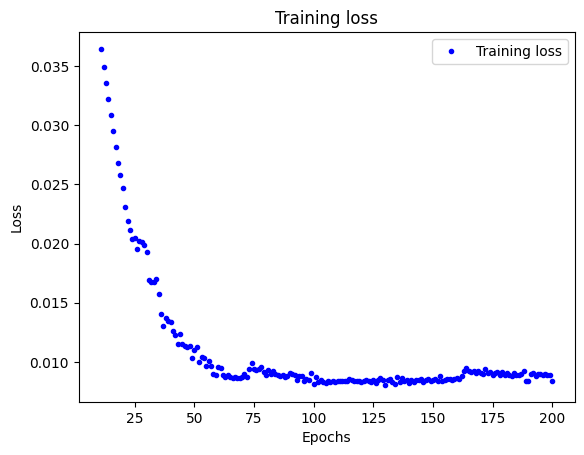

In [ ]:
SKIP = 10
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs[SKIP:], training_loss[SKIP:], 'b.', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

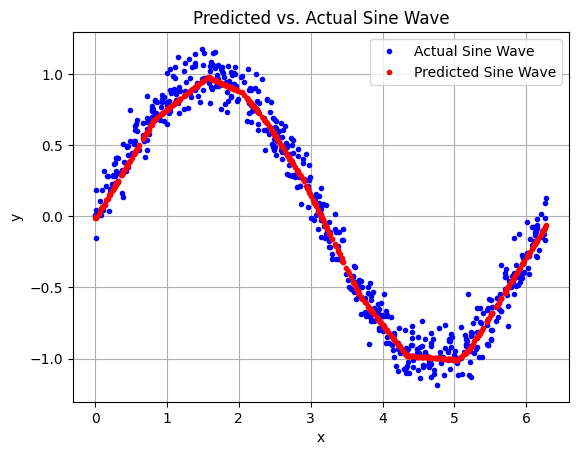

In [ ]:
# Prepare data for plotting
x_train_np = x_train.squeeze().numpy()  # Convert tensor to numpy array for plotting
y_train_np = y_train.squeeze().numpy()
predicted_y_np = predicted_y.squeeze().detach().numpy()

# Plotting
plt.plot(x_train_np, y_train_np, '.b', label='Actual Sine Wave')
plt.plot(x_train_np, predicted_y_np, '.r', label='Predicted Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Predicted vs. Actual Sine Wave')
plt.grid(True)
plt.show()

In [ ]:
# Print the weights matrix of the model before quantization
print('Weights before quantization')
print(model.fc1.weight)
print(model.fc1.weight.dtype)

Weights before quantization
Parameter containing:
tensor([[-0.2688],
        [-0.1595],
        [-0.8751],
        [ 0.4073],
        [ 0.3814],
        [ 0.0951],
        [ 0.2700],
        [-0.2657],
        [ 0.1795],
        [ 0.2749],
        [ 0.0614],
        [ 0.5033],
        [ 0.5057],
        [-0.1864],
        [ 0.4885],
        [ 0.4640]], requires_grad=True)
torch.float32


In [ ]:
print('Size of the model before quantization')
print_size_of_model(model)

Size of the model before quantization
Size (KB): 3.942


In [ ]:
test(model, x_train, y_train)

Accuracy: 0.012


We need to quantize the model to optimize for the hardware implementation.

In [ ]:
# Quantization after training
class QuantizedSinePredictor(nn.Sequential):
  def __init__(self, input_size, hidden_size, output_size):
    super(QuantizedSinePredictor, self).__init__()
    self.quant = torch.quantization.QuantStub()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.dequant = torch.quantization.DeQuantStub()

  def forward(self, x):
    x = self.quant(x)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dequant(x)
    return x

In [ ]:
# Prepare for quantization
model_quantized = QuantizedSinePredictor (input_size, hidden_size, output_size)

# Copy weights from unquantized model
model_quantized.load_state_dict(model.state_dict())
model_quantized.eval()

model_quantized.qconfig = torch.ao.quantization.QConfig(torch.ao.quantization.MinMaxObserver.with_args(dtype=torch.qint8),torch.ao.quantization.default_weight_observer)
model_quantized = torch.ao.quantization.prepare(model_quantized) # Insert observers
model_quantized

QuantizedSinePredictor(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (fc1): Linear(
    in_features=1, out_features=16, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU()
  (fc2): Linear(
    in_features=16, out_features=16, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (fc3): Linear(
    in_features=16, out_features=1, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
)

In [ ]:
test(model_quantized, x_train, y_train)

Accuracy: 0.012


In [ ]:
print(f'Check statistics of the various layers')
model_quantized

Check statistics of the various layers


QuantizedSinePredictor(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=0.005220395512878895, max_val=6.280028343200684)
  )
  (fc1): Linear(
    in_features=1, out_features=16, bias=True
    (activation_post_process): MinMaxObserver(min_val=-5.952820777893066, max_val=4.192022800445557)
  )
  (relu): ReLU()
  (fc2): Linear(
    in_features=16, out_features=16, bias=True
    (activation_post_process): MinMaxObserver(min_val=-3.575362205505371, max_val=2.230142831802368)
  )
  (fc3): Linear(
    in_features=16, out_features=1, bias=True
    (activation_post_process): MinMaxObserver(min_val=-1.008575439453125, max_val=0.9770274758338928)
  )
  (dequant): DeQuantStub()
)

In [ ]:
model_quantized = torch.ao.quantization.convert(model_quantized)

In [ ]:
print(f'Check statistics of the various layers')
model_quantized

Check statistics of the various layers


QuantizedSinePredictor(
  (quant): Quantize(scale=tensor([0.0246]), zero_point=tensor([-128]), dtype=torch.qint8)
  (fc1): QuantizedLinear(in_features=1, out_features=16, scale=0.03978370130062103, zero_point=22, qscheme=torch.per_tensor_affine)
  (relu): ReLU()
  (fc2): QuantizedLinear(in_features=16, out_features=16, scale=0.022766685113310814, zero_point=29, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=16, out_features=1, scale=0.007786677684634924, zero_point=2, qscheme=torch.per_tensor_affine)
  (dequant): DeQuantize()
)

In [ ]:
# Print the weights matrix of the model after quantization
print('Weights after quantization')
print(torch.int_repr(model_quantized.fc1.weight()))

Weights after quantization
tensor([[ -39],
        [ -23],
        [-128],
        [  59],
        [  56],
        [  14],
        [  39],
        [ -39],
        [  26],
        [  40],
        [   9],
        [  73],
        [  74],
        [ -27],
        [  71],
        [  68]], dtype=torch.int8)


In [ ]:
print('Original weights: ')
print(model.fc1.weight)
print('')
print(f'Dequantized weights: ')
print(torch.dequantize(model_quantized.fc1.weight()))
print('')

Original weights: 
Parameter containing:
tensor([[-0.2688],
        [-0.1595],
        [-0.8751],
        [ 0.4073],
        [ 0.3814],
        [ 0.0951],
        [ 0.2700],
        [-0.2657],
        [ 0.1795],
        [ 0.2749],
        [ 0.0614],
        [ 0.5033],
        [ 0.5057],
        [-0.1864],
        [ 0.4885],
        [ 0.4640]], requires_grad=True)

Dequantized weights: 
tensor([[-0.2677],
        [-0.1579],
        [-0.8785],
        [ 0.4050],
        [ 0.3844],
        [ 0.0961],
        [ 0.2677],
        [-0.2677],
        [ 0.1785],
        [ 0.2745],
        [ 0.0618],
        [ 0.5010],
        [ 0.5079],
        [-0.1853],
        [ 0.4873],
        [ 0.4667]])



In [ ]:
print('Size of the model after quantization')
print_size_of_model(model_quantized)

Size of the model after quantization
Size (KB): 5.474


In [ ]:
print('Testing the model after quantization')
test(model_quantized, x_train, y_train)

Testing the model after quantization


RuntimeError: quantized::linear (xnnpack): Input tensor rank should be >= 2.

In [ ]:
model(torch.tensor(5.0))

RuntimeError: ArrayRef: invalid index Index = 18446744073709551615; Length = 0

Plot the predicted data from the quantized model

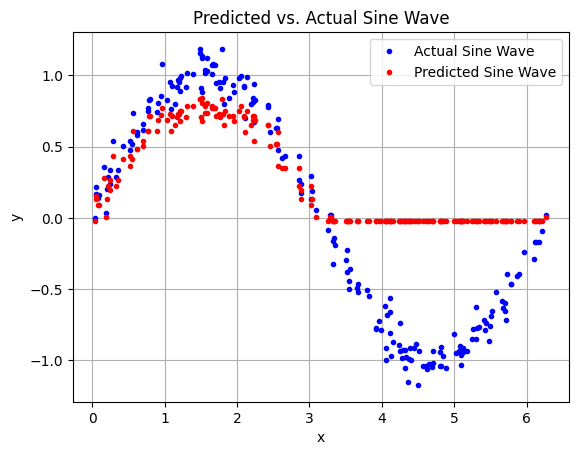

In [ ]:
# Prepare data for plotting
predicted_y_q = model_quantized(y_test)
predicted_y_q_np = predicted_y_q.squeeze().detach().numpy()

# Plotting
plt.plot(x_test_np, y_test_np, '.b', label='Actual Sine Wave')
plt.plot(x_test_np, predicted_y_q_np, '.r', label='Predicted Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Predicted vs. Actual Sine Wave')
plt.grid(True)
plt.show()

Not sure how this next step works, but it is what converts the model to Verilog.

In [ ]:
model_converter = Model(model_quantized)
model_converter.parse_layers()
model_converter.forward_range([[1.0, 100.0]])

In [ ]:
print(model_converter)
verilog = model_converter.emit()

In [ ]:
print(verilog)

Generate the test bench

In [ ]:
verilog_tb = model_converter.emit_test_bench()
print(verilog_tb)

The next steps saves the verilog module and the testbench to a file.

In [ ]:
with open('test.v', 'w') as f:
    f.write(verilog)

with open('test_tb.v', 'w') as f:
    f.write(verilog_tb)

## References
- [The Hello World of Deep Learning with Neural Networks](https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb)
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0?source=collection_category---4------1-----------------------)
- [PyTorch Official Docs](https://pytorch.org/docs/stable/nn.html)
- [PyTorch 1.2 Quickstart with Google Colab](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)
- [A Gentle Intoduction to PyTorch](https://medium.com/dair-ai/pytorch-1-2-introduction-guide-f6fa9bb7597c)